In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
def get_option_data(ticker, start_date, end_date):
    # Download stock data
    stock = yf.Ticker(ticker)
    
    # Get all option expiration dates
    expirations = stock.options
    
    call_options = pd.DataFrame()
    
    for expiration in expirations:
        # Get option chain for this expiration
        opt = stock.option_chain(expiration)
        
        # fetch all call options
        options = opt.calls
        
        # Add expiration date to the dataframe
        options['Expiration'] = pd.to_datetime(expiration).date()
    
        # Combine all options data
        call_options = pd.concat([call_options, options], ignore_index=True)
    
    # Get historical stock data
    hist_data = stock.history(start=start_date, end=end_date)
    
    # Normalize historical data index to date without timezone
    hist_data.index = hist_data.index.date
    
    # Merge options data with historical stock data
    merged_data = pd.merge(call_options, hist_data, left_on='Expiration', right_index=True, how='left')
    
    return merged_data

ticker = "AAPL" 
end_date = datetime.now()
start_date = end_date - timedelta(days=30)  # Last 30 days

option_data = get_option_data(ticker, start_date, end_date)
option_data = option_data.iloc[:,:-7]
option_data = option_data.dropna()
option_data = option_data.drop(columns=['contractSize', 'currency','contractSymbol'])
option_data['lastTradeDate'] = pd.to_datetime(option_data['lastTradeDate']).dt.date

# Display the first few rows of the data
print(option_data.head())

# Save to CSV
option_data.to_csv(f"{ticker}_option_data.csv", index=False)


  lastTradeDate  strike  lastPrice     bid    ask    change  percentChange  \
0    2024-06-28   100.0     113.50  115.75  118.1  0.000000       0.000000   
2    2024-07-01   110.0     107.35  105.75  108.1  3.199997       3.072488   
3    2024-06-28   125.0      88.39   90.85   93.2  0.000000       0.000000   
4    2024-06-28   130.0      84.01   85.75   88.1  0.000000       0.000000   
5    2024-06-28   135.0      79.65   80.65   83.2  0.000000       0.000000   

   volume  openInterest  impliedVolatility  inTheMoney  Expiration  
0     7.0             9           2.863284        True  2024-07-05  
2     1.0             1           2.539066        True  2024-07-05  
3     2.0             2           2.236333        True  2024-07-05  
4     1.0             1           1.964844        True  2024-07-05  
5     4.0             7           1.832032        True  2024-07-05  


In [4]:
# Assume the data is in a DataFrame called 'df'
df = pd.read_csv(f'{ticker}_option_data.csv')

df['duration'] = (pd.to_datetime(df['Expiration']) - pd.to_datetime(df['lastTradeDate'])).dt.days
# Sort by date
df = df.sort_values('lastTradeDate')

# Select relevant features
features = ['strike', 'bid', 'ask', 'change', 'percentChange', 'volume', 
            'openInterest', 'impliedVolatility','duration']


# Normalize the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# Prepare input features and target variable
X = df.drop(['lastPrice','inTheMoney','Expiration','lastTradeDate'], axis=1)
y = df['lastPrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values).view(-1,1)
y_test = torch.FloatTensor(y_test.values).view(-1,1)

# Create DataLoader for batch processing
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = x.unsqueeze(1).to(device)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, (h1,c1) = self.lstm1(x, (h0, c0))
        out = self.dropout1(out)
        out, _ = self.lstm2(out, (h1,c1))
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :]) 
        return out

input_dim = len(features)
hidden_dim = 512
layer_dim = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)


In [15]:
# training model
criterion = nn.MSELoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Reduce LR by 90% every 10 epochs

num_epochs = 100
best_loss = float('inf')
model_save_path = "best_model.pth"

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    epoch_loss = 0

    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to GPU  
        outputs = model(batch_X)
        optimizer.zero_grad()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()   
        epoch_loss += loss.item()
            
       
    avg_epoch_loss = epoch_loss / len(train_loader)
    print({'loss': avg_epoch_loss})    
    
    
    # Step the scheduler
    scheduler.step()

    # Save the model if it has the best loss so far
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save(model.state_dict(), model_save_path)
print("Training completed successfully")

Training Epochs:   1%|          | 1/100 [00:00<00:40,  2.45it/s]

{'loss': 4196.486657184103}


Training Epochs:   2%|▏         | 2/100 [00:00<00:33,  2.90it/s]

{'loss': 2945.2173541525135}


Training Epochs:   3%|▎         | 3/100 [00:01<00:33,  2.88it/s]

{'loss': 1945.6385730245838}


Training Epochs:   4%|▍         | 4/100 [00:01<00:32,  2.91it/s]

{'loss': 1315.393544404403}


Training Epochs:   5%|▌         | 5/100 [00:01<00:31,  3.00it/s]

{'loss': 940.823349662449}


Training Epochs:   6%|▌         | 6/100 [00:02<00:31,  3.02it/s]

{'loss': 700.571373483409}


Training Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.08it/s]

{'loss': 559.7161043415899}


Training Epochs:   8%|▊         | 8/100 [00:02<00:30,  3.05it/s]

{'loss': 446.7346432727316}


Training Epochs:   9%|▉         | 9/100 [00:02<00:29,  3.10it/s]

{'loss': 377.97396780096966}


Training Epochs:  10%|█         | 10/100 [00:03<00:28,  3.14it/s]

{'loss': 323.903216154679}


Training Epochs:  11%|█         | 11/100 [00:03<00:28,  3.16it/s]

{'loss': 306.1694226472274}


Training Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.15it/s]

{'loss': 270.0642490801604}


Training Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.18it/s]

{'loss': 280.1542270494544}


Training Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.23it/s]

{'loss': 261.7084610151208}


Training Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.22it/s]

{'loss': 252.74183741859767}


Training Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.14it/s]

{'loss': 207.4474155591882}


Training Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.17it/s]

{'loss': 199.97923444664997}


Training Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.18it/s]

{'loss': 169.11249409551206}


Training Epochs:  19%|█▉        | 19/100 [00:06<00:24,  3.31it/s]

{'loss': 177.84565834377122}


Training Epochs:  20%|██        | 20/100 [00:06<00:24,  3.22it/s]

{'loss': 165.7864059365314}


Training Epochs:  21%|██        | 21/100 [00:06<00:23,  3.31it/s]

{'loss': 202.0453982975172}


Training Epochs:  22%|██▏       | 22/100 [00:06<00:23,  3.37it/s]

{'loss': 203.58292720628822}


Training Epochs:  23%|██▎       | 23/100 [00:07<00:22,  3.43it/s]

{'loss': 171.73419877757198}


Training Epochs:  24%|██▍       | 24/100 [00:07<00:21,  3.50it/s]

{'loss': 175.96140131743059}


Training Epochs:  25%|██▌       | 25/100 [00:07<00:21,  3.51it/s]

{'loss': 181.7842039439989}


Training Epochs:  26%|██▌       | 26/100 [00:08<00:21,  3.39it/s]

{'loss': 138.1794960187829}


Training Epochs:  27%|██▋       | 27/100 [00:08<00:21,  3.41it/s]

{'loss': 146.95612799603006}


Training Epochs:  28%|██▊       | 28/100 [00:08<00:21,  3.36it/s]

{'loss': 135.02518500452456}


Training Epochs:  29%|██▉       | 29/100 [00:09<00:21,  3.25it/s]

{'loss': 120.1966265388157}


Training Epochs:  30%|███       | 30/100 [00:09<00:21,  3.30it/s]

{'loss': 147.24410538051438}


Training Epochs:  31%|███       | 31/100 [00:09<00:21,  3.24it/s]

{'loss': 113.10219484826793}


Training Epochs:  32%|███▏      | 32/100 [00:09<00:21,  3.20it/s]

{'loss': 86.78174041665119}


Training Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.15it/s]

{'loss': 75.75758353523587}


Training Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.15it/s]

{'loss': 69.96344155850618}


Training Epochs:  35%|███▌      | 35/100 [00:10<00:19,  3.26it/s]

{'loss': 70.5656068843344}


Training Epochs:  36%|███▌      | 36/100 [00:11<00:19,  3.31it/s]

{'loss': 63.482942197633825}


Training Epochs:  37%|███▋      | 37/100 [00:11<00:18,  3.38it/s]

{'loss': 64.79144561809042}


Training Epochs:  38%|███▊      | 38/100 [00:11<00:18,  3.35it/s]

{'loss': 58.61644749019457}


Training Epochs:  39%|███▉      | 39/100 [00:12<00:17,  3.43it/s]

{'loss': 59.180707330289096}


Training Epochs:  40%|████      | 40/100 [00:12<00:17,  3.34it/s]

{'loss': 54.80697629762732}


Training Epochs:  41%|████      | 41/100 [00:12<00:17,  3.32it/s]

{'loss': 53.45033682947574}


Training Epochs:  42%|████▏     | 42/100 [00:13<00:17,  3.31it/s]

{'loss': 52.03517978087716}


Training Epochs:  43%|████▎     | 43/100 [00:13<00:16,  3.43it/s]

{'loss': 52.85773001546445}


Training Epochs:  44%|████▍     | 44/100 [00:13<00:16,  3.35it/s]

{'loss': 49.96231990275176}


Training Epochs:  45%|████▌     | 45/100 [00:13<00:16,  3.43it/s]

{'loss': 55.91392706788105}


Training Epochs:  46%|████▌     | 46/100 [00:14<00:15,  3.48it/s]

{'loss': 53.30832369431205}


Training Epochs:  47%|████▋     | 47/100 [00:14<00:15,  3.37it/s]

{'loss': 49.64355122524759}


Training Epochs:  48%|████▊     | 48/100 [00:14<00:15,  3.43it/s]

{'loss': 50.224207339079484}


Training Epochs:  49%|████▉     | 49/100 [00:15<00:15,  3.40it/s]

{'loss': 49.3551010152568}


Training Epochs:  50%|█████     | 50/100 [00:15<00:14,  3.35it/s]

{'loss': 49.1703640067059}


Training Epochs:  51%|█████     | 51/100 [00:15<00:14,  3.29it/s]

{'loss': 48.68851611925208}


Training Epochs:  52%|█████▏    | 52/100 [00:15<00:14,  3.28it/s]

{'loss': 48.586580856986664}


Training Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.23it/s]

{'loss': 47.7783727645874}


Training Epochs:  54%|█████▍    | 54/100 [00:16<00:14,  3.19it/s]

{'loss': 46.24871351407922}


Training Epochs:  55%|█████▌    | 55/100 [00:16<00:14,  3.20it/s]

{'loss': 43.214983048646346}


Training Epochs:  56%|█████▌    | 56/100 [00:17<00:13,  3.20it/s]

{'loss': 43.18208329573922}


Training Epochs:  57%|█████▋    | 57/100 [00:17<00:12,  3.33it/s]

{'loss': 43.22938017223192}


Training Epochs:  58%|█████▊    | 58/100 [00:17<00:12,  3.43it/s]

{'loss': 43.99801134026569}


Training Epochs:  59%|█████▉    | 59/100 [00:18<00:12,  3.39it/s]

{'loss': 42.78681798603224}


Training Epochs:  60%|██████    | 60/100 [00:18<00:11,  3.43it/s]

{'loss': 42.8769952421603}


Training Epochs:  61%|██████    | 61/100 [00:18<00:11,  3.37it/s]

{'loss': 41.74068801299386}


Training Epochs:  62%|██████▏   | 62/100 [00:18<00:11,  3.32it/s]

{'loss': 39.61241595641427}


Training Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.32it/s]

{'loss': 38.55235597361689}


Training Epochs:  64%|██████▍   | 64/100 [00:19<00:10,  3.32it/s]

{'loss': 37.60775792080423}


Training Epochs:  65%|██████▌   | 65/100 [00:19<00:10,  3.42it/s]

{'loss': 39.491849484650984}


Training Epochs:  66%|██████▌   | 66/100 [00:20<00:09,  3.51it/s]

{'loss': 38.67132543480915}


Training Epochs:  67%|██████▋   | 67/100 [00:20<00:09,  3.55it/s]

{'loss': 38.19547715394393}


Training Epochs:  68%|██████▊   | 68/100 [00:20<00:09,  3.53it/s]

{'loss': 38.596715916758}


Training Epochs:  69%|██████▉   | 69/100 [00:20<00:08,  3.59it/s]

{'loss': 40.38763937742814}


Training Epochs:  70%|███████   | 70/100 [00:21<00:08,  3.62it/s]

{'loss': 38.27197243856347}


Training Epochs:  71%|███████   | 71/100 [00:21<00:08,  3.51it/s]

{'loss': 35.95023811381796}


Training Epochs:  72%|███████▏  | 72/100 [00:21<00:08,  3.47it/s]

{'loss': 38.35676456534344}


Training Epochs:  73%|███████▎  | 73/100 [00:22<00:07,  3.51it/s]

{'loss': 36.97673907487289}


Training Epochs:  74%|███████▍  | 74/100 [00:22<00:07,  3.52it/s]

{'loss': 36.104884111362956}


Training Epochs:  75%|███████▌  | 75/100 [00:22<00:07,  3.51it/s]

{'loss': 37.987097107845806}


Training Epochs:  76%|███████▌  | 76/100 [00:22<00:06,  3.55it/s]

{'loss': 38.80702231241309}


Training Epochs:  77%|███████▋  | 77/100 [00:23<00:06,  3.44it/s]

{'loss': 35.67209996347842}


Training Epochs:  78%|███████▊  | 78/100 [00:23<00:06,  3.52it/s]

{'loss': 37.037836344345756}


Training Epochs:  79%|███████▉  | 79/100 [00:23<00:05,  3.54it/s]

{'loss': 38.7225081609643}


Training Epochs:  80%|████████  | 80/100 [00:24<00:05,  3.53it/s]

{'loss': 36.571674502414204}


Training Epochs:  81%|████████  | 81/100 [00:24<00:05,  3.52it/s]

{'loss': 36.68809197778287}


Training Epochs:  82%|████████▏ | 82/100 [00:24<00:05,  3.55it/s]

{'loss': 36.54998893323152}


Training Epochs:  83%|████████▎ | 83/100 [00:24<00:04,  3.56it/s]

{'loss': 38.29581596540368}


Training Epochs:  84%|████████▍ | 84/100 [00:25<00:04,  3.62it/s]

{'loss': 36.183840679085776}


Training Epochs:  85%|████████▌ | 85/100 [00:25<00:04,  3.61it/s]

{'loss': 37.363331882849984}


Training Epochs:  86%|████████▌ | 86/100 [00:25<00:03,  3.63it/s]

{'loss': 36.60248153106026}


Training Epochs:  87%|████████▋ | 87/100 [00:26<00:03,  3.62it/s]

{'loss': 36.33321702998617}


Training Epochs:  88%|████████▊ | 88/100 [00:26<00:03,  3.66it/s]

{'loss': 36.08841861849246}


Training Epochs:  89%|████████▉ | 89/100 [00:26<00:03,  3.66it/s]

{'loss': 36.640268149583235}


Training Epochs:  90%|█████████ | 90/100 [00:26<00:02,  3.52it/s]

{'loss': 35.122134664784305}


Training Epochs:  91%|█████████ | 91/100 [00:27<00:02,  3.37it/s]

{'loss': 34.07457434612772}


Training Epochs:  92%|█████████▏| 92/100 [00:27<00:02,  3.45it/s]

{'loss': 35.907422008721724}


Training Epochs:  93%|█████████▎| 93/100 [00:27<00:01,  3.52it/s]

{'loss': 38.10879908437314}


Training Epochs:  94%|█████████▍| 94/100 [00:28<00:01,  3.54it/s]

{'loss': 34.31537922568943}


Training Epochs:  95%|█████████▌| 95/100 [00:28<00:01,  3.60it/s]

{'loss': 37.209863704183824}


Training Epochs:  96%|█████████▌| 96/100 [00:28<00:01,  3.64it/s]

{'loss': 37.47125433320584}


Training Epochs:  97%|█████████▋| 97/100 [00:28<00:00,  3.64it/s]

{'loss': 34.83934209657752}


Training Epochs:  98%|█████████▊| 98/100 [00:29<00:00,  3.69it/s]

{'loss': 35.0955678380054}


Training Epochs:  99%|█████████▉| 99/100 [00:29<00:00,  3.68it/s]

{'loss': 36.002807461697124}


Training Epochs: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]

{'loss': 36.06053694434788}
Training completed successfully


In [20]:
# model evaluation
# Load the best model after training
model.load_state_dict(torch.load(model_save_path))

model.eval()
test_loss = 0
true_values = []
predicted_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to GPU
        outputs = model(batch_X)
        test_loss += criterion(outputs, batch_y).item()

        # Collect true and predicted values for plotting
        true_values.extend(batch_y.cpu().numpy().flatten())
        predicted_values.extend(outputs.cpu().numpy().flatten())

print(f'Final Test Loss: {test_loss/len(test_loader):.4f}')

Final Test Loss: 48.2588


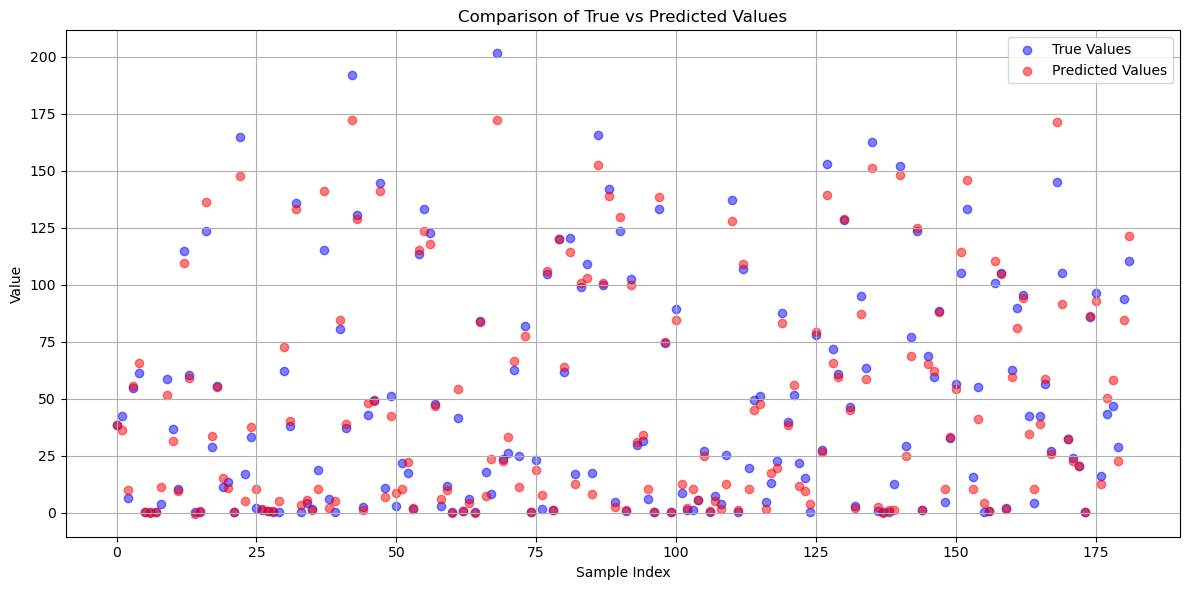

In [21]:
# Create the comparison graph

plt.figure(figsize=(12, 6))
plt.scatter(range(len(true_values)), true_values, color='blue', label='True Values', alpha=0.5)
plt.scatter(range(len(predicted_values)), predicted_values, color='red', label='Predicted Values', alpha=0.5)
plt.title('Comparison of True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()